# Test of different classification models

In [4]:
from preprocessing import spans_add_tokens
from data_loader import train_data_loader, make_span_data
from classification_metrics import plot_confusion_matrix

import json
import numpy as np
from statistics import mean
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import fasttext
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import time
from joblib import dump, load


## Data pre-processing and loading

In [17]:
def make_feature_vectors_and_labels(spans):
    # function takes long to execute
    # note: we un-sparse the matrix here to be able to manipulate it
    list_nb_of_tokens = []
    fasttext_vectorizer = []
    for sent in spans:
        temp_feature = []
        list_nb_of_tokens.append(len(sent['tokens_spacy']))
        for token in sent['tokens_spacy']:
            temp_feature.append(model.get_word_vector(token))
        np.array(temp_feature)
        fasttext_vectorizer.append(np.average(temp_feature, axis=0)) #possible to weight it with tfidf
    mean_nb_tokens = mean(list_nb_of_tokens)
    std_nb_tokens = np.std(np.array(list_nb_of_tokens))
    fasttext_vectorizer  =np.array(fasttext_vectorizer)

    print("fasttext vect: ", fasttext_vectorizer.shape)
    starts_normalized = np.array([s['start_normalized'] for s in spans])
    print("starts: ", starts_normalized.shape)
    nb_tokens_normalized = np.array([(len(s['tokens_spacy'])-mean_nb_tokens)/std_nb_tokens for s in spans])
    print("number: ", nb_tokens_normalized.shape)
    y = np.array([s['type'] for s in spans])
    temp = np.concatenate((fasttext_vectorizer, np.expand_dims(starts_normalized, axis=1)), axis=1)
    X = np.concatenate((temp, np.expand_dims(nb_tokens_normalized, axis=1)), axis=1)
    print("X and y created")
    return X, y

model = fasttext.load_model("../models/model_fasttext.bin")

corpus_fpath = '../labeled/ldsi_w21_curated_annotations_v2.json'
data = json.load(open(corpus_fpath))
print("****TRAIN****")
data_train = train_data_loader(data, "../labeled/curated_annotations_split.yml")
train_spans, train_spans_labels, train_spans_txt = make_span_data(data_train)
spans_add_tokens(train_spans)
train_X, train_y = make_feature_vectors_and_labels(train_spans)
print(f'{train_X.shape} {train_y.shape}')
print("****DEV****")
data_dev = train_data_loader(data, "../labeled/curated_annotations_split.yml", set_of_data="dev")
dev_spans, dev_spans_labels, dev_spans_txt = make_span_data(data_dev)
spans_add_tokens(dev_spans)
dev_X, dev_y = make_feature_vectors_and_labels(dev_spans)
print(f'{dev_X.shape} {dev_y.shape}')

****TRAIN****
---Training data loaded
---Spanning dataset completed 291  /14 291 3286  /14 291 /14 291 5619  /14 291 /14 2918006  /14 2918390  /14 291 /14 291
---Number of tokens key added to spans51  / 14 291
fasttext vect:  (14292, 100)
starts:  (14292,)
number:  (14292,)
X and y created
(14292, 102) (14292,)
****DEV****
---Development data loaded
---Spanning dataset completed
---Number of tokens key added to spans
fasttext vect:  (448, 100)
starts:  (448,)
number:  (448,)
X and y created
(448, 102) (448,)


/home/mahaut/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mahaut/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mahaut/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being 

TRAIN LR:
                                    precision    recall  f1-score   support

                        CaseFooter       0.99      0.99      0.99       131
                        CaseHeader       0.98      0.98      0.98       133
                         CaseIssue       0.92      0.98      0.95       133
                          Citation       0.98      0.98      0.98      2260
                   ConclusionOfLaw       0.83      0.81      0.82       319
                          Evidence       0.82      0.92      0.87      4347
EvidenceBasedOrIntermediateFinding       0.64      0.56      0.60      1373
            EvidenceBasedReasoning       0.48      0.28      0.36       943
                            Header       0.99      0.99      0.99      1385
                         LegalRule       0.80      0.89      0.84      1807
              LegislationAndPolicy       0.68      0.34      0.45       160
              PolicyBasedReasoning       0.00      0.00      0.00        27
 

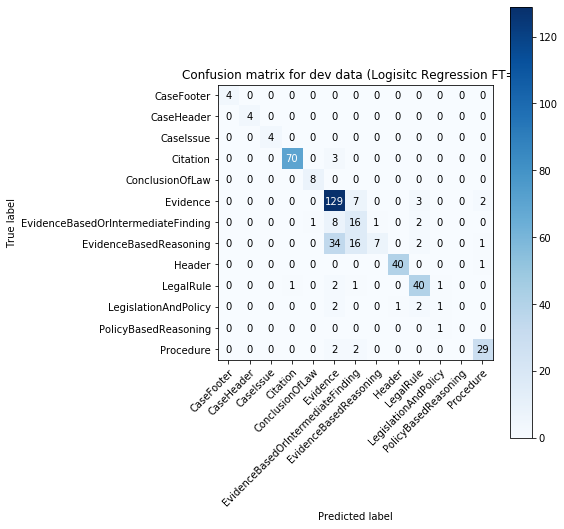

In [20]:
clf = RandomForestClassifier(n_estimators=40, criterion='entropy', max_depth=30)
#clf = LogisticRegression()
clf = clf.fit(train_X, train_y)
dump(clf, '../models/random_forest_best.joblib')
#print('TRAIN LR:\n'+classification_report(train_spans_labels, clf.predict(train_X)))
#print('DEV TEST LR:\n'+classification_report(dev_spans_labels, clf.predict(dev_X)))
#plot_confusion_matrix(dev_spans_labels, clf.predict(dev_X), classes=list(clf.classes_),
 #                     title='Confusion matrix for dev data (Logisitc Regression FT=3)')
#plt.show()

## Grid search for Random Forest Classifier

In [24]:
param_grid = {'n_estimators': [35, 40, 45],
                'criterion': ['gini', 'entropy'],
                'max_depth': [25, 30, 35]}
n_estimators_parameter = []
criterion_parameter = []
max_depth_parameter = []
test_accuracy_list = []
test_macro_avg_list = []
test_weigthed_avg_list = []
train_accuracy_list = []
train_macro_avg_list = []
train_weigthed_avg_list = []
for nb_est in param_grid['n_estimators']:
    for crit in param_grid['criterion']:
        for depth in param_grid['max_depth']:
            clf = RandomForestClassifier(n_estimators = nb_est, criterion= crit, max_depth=depth)
            clf = clf.fit(train_X, train_y)
            results = classification_report(dev_spans_labels, clf.predict(dev_X), output_dict=True)
            train_results = classification_report(train_spans_labels, clf.predict(train_X), output_dict=True)
            
            test_accuracy_list.append(results['accuracy'])
            test_macro_avg_list.append(results['macro avg']['f1-score'])
            test_weigthed_avg_list.append(results['weighted avg']['f1-score'])
            train_accuracy_list.append(train_results['accuracy'])
            train_macro_avg_list.append(train_results['macro avg']['f1-score'])
            train_weigthed_avg_list.append(train_results['weighted avg']['f1-score'])
            n_estimators_parameter.append(nb_est)
            criterion_parameter.append(crit)
            max_depth_parameter.append(depth)

/home/mahaut/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mahaut/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mahaut/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mahaut/.local/lib/python3.8/site-p

,nb estimators,criterion,max depth,test accuracy,test macro avg,test weighted avg,train accuracy,train macro avg,train weighted avg
0,35,gini,25,0.779018,0.697018,0.739459,0.99923,0.998204,0.999229
1,35,gini,30,0.783482,0.70708,0.749378,0.9993,0.999337,0.9993
2,35,gini,35,0.787946,0.703543,0.747369,0.99909,0.999203,0.99909
3,35,entropy,25,0.770089,0.683777,0.72674,0.99951,0.999045,0.99951
4,35,entropy,30,0.763393,0.680489,0.720301,0.99958,0.997975,0.99958
5,35,entropy,35,0.787946,0.711997,0.741173,0.99965,0.999359,0.99965
6,40,gini,25,0.774554,0.700427,0.730767,0.99937,0.998967,0.99937
7,40,gini,30,0.770089,0.668662,0.726316,0.99986,0.999463,0.99986
8,40,gini,35,0.776786,0.689289,0.730015,0.99972,0.99959,0.99972
9,40,entropy,25,0.787946,0.696239,0.737763,0.99986,0.999463,0.99986


In [25]:
results_list = [n_estimators_parameter, criterion_parameter, max_depth_parameter, test_accuracy_list, test_macro_avg_list, test_weigthed_avg_list, train_accuracy_list, train_macro_avg_list, train_weigthed_avg_list]

df = pd.DataFrame (results_list).transpose()
df.columns = ['nb estimators', 'criterion', 'max depth', 'test accuracy', 'test macro avg', 'test weighted avg', 'train accuracy', 'train macro avg', 'train weighted avg']
df

,nb estimators,criterion,max depth,test accuracy,test macro avg,test weighted avg,train accuracy,train macro avg,train weighted avg
0,35,gini,25,0.779018,0.697018,0.739459,0.99923,0.998204,0.999229
1,35,gini,30,0.783482,0.70708,0.749378,0.9993,0.999337,0.9993
2,35,gini,35,0.787946,0.703543,0.747369,0.99909,0.999203,0.99909
3,35,entropy,25,0.770089,0.683777,0.72674,0.99951,0.999045,0.99951
4,35,entropy,30,0.763393,0.680489,0.720301,0.99958,0.997975,0.99958
5,35,entropy,35,0.787946,0.711997,0.741173,0.99965,0.999359,0.99965
6,40,gini,25,0.774554,0.700427,0.730767,0.99937,0.998967,0.99937
7,40,gini,30,0.770089,0.668662,0.726316,0.99986,0.999463,0.99986
8,40,gini,35,0.776786,0.689289,0.730015,0.99972,0.99959,0.99972
9,40,entropy,25,0.787946,0.696239,0.737763,0.99986,0.999463,0.99986


## Cross validation

In [41]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
clf = RandomForestClassifier(n_estimators = 40, criterion= 'entropy', max_depth=30)
#clf = LogisticRegression()

acc_scores = cross_val_score(clf, train_X, train_y, scoring='accuracy', cv=cv, n_jobs=5)
print("accuracy: ", acc_scores, mean(acc_scores), np.std(acc_scores))
macro_avg_scores = cross_val_score(clf, train_X, train_y, scoring='f1_macro', cv=cv, n_jobs=5)
print("macro avg: ", macro_avg_scores, mean(macro_avg_scores), np.std(macro_avg_scores))
w_avg_scores = cross_val_score(clf, train_X, train_y, scoring='f1_weighted', cv=cv, n_jobs=5)
print("weighted avg: ", w_avg_scores, mean(w_avg_scores), np.std(w_avg_scores))

print("*********Actual test**********")
clf = clf.fit(train_X, train_y)
results = classification_report(dev_spans_labels, clf.predict(dev_X), output_dict=True)
print("accuracy", results['accuracy'])
print("macro avg", results['macro avg']['f1-score'])
print("weighted avg", results['weighted avg']['f1-score'])

accuracy:  [0.80559441 0.81958042 0.82295311 0.82995101 0.80545836 0.8096571
 0.82785164 0.83414976 0.83275017 0.80615815] 0.8194104146378465 0.011164349508902915
macro avg:  [0.69465916 0.70721204 0.64967241 0.78033924 0.65074314 0.69604477
 0.72675502 0.70120081 0.66979807 0.70747857] 0.6983903243667601 0.03628929382651971
weighted avg:  [0.78197772 0.80114152 0.79522383 0.81798977 0.78579296 0.80097388
 0.7988013  0.81028373 0.81418752 0.79096042] 0.7997332650063063 0.011246412161348574
*********Actual test**********
accuracy 0.7633928571428571
macro avg 0.6786902019788094
weighted avg 0.7148338875448764


/home/mahaut/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mahaut/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mahaut/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Time comparison between Logistic Regression and Random Forest classifier

In [44]:
start = time.time()
clf = RandomForestClassifier(n_estimators = 40, criterion= 'entropy', max_depth=30)
clf = clf.fit(train_X, train_y)
clf.predict(dev_X)
print("Time for random forest: ", time.time()-start)

start = time.time()
clf = LogisticRegression()
clf = clf.fit(train_X, train_y)
clf.predict(dev_X)
print("Time for logistic regression: ", time.time()-start)

Time for random forest:  8.543424129486084
Time for logistic regression:  2.176591634750366


/home/mahaut/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Save and load model

In [50]:
dump(clf, 'models/test.joblib') 

['models/test.joblib']

In [54]:
print(dev_X[0])
clf.predict(dev_X[0].reshape(1, -1))

[ 0.43434018 -0.76266938 -0.72776008 -0.04971385 -0.81622642 -1.0957588
  0.66090751 -0.42513523 -0.63757956  0.1321056  -0.57617265  0.21619111
 -1.35295117  0.07218578 -0.69623464  0.13489652 -1.05523515  0.06235587
 -0.23070011 -0.51808745  0.70262825  0.27307975  0.72548354  0.02204542
  1.08666337  0.095121    0.03576133 -0.03262304 -0.91807687 -0.62758338
  0.6619097  -0.91999573  0.84403092 -0.58134353  0.06983472 -0.78008884
  0.68185544 -0.36833152 -1.0142113   0.13101107 -0.52855176  0.1577891
 -0.64852422 -0.99557817 -0.77650791 -0.77513164  0.53609425 -0.79515082
 -1.02146792  0.54792172  0.08673637 -0.20893501 -0.28455493 -0.01895404
  0.51808524  0.38576782 -0.56329739  1.12613153  0.40786985  0.68549895
 -0.56211209  0.24534954 -0.4262059  -0.06193816 -0.25924119 -0.17011338
 -0.63627118  0.50844008 -0.39066151  0.96235603  0.88725686 -0.0977798
 -0.80629212  0.51765215  0.13798232  0.5144769  -0.66490895 -0.14552192
  0.70607483 -0.468591    0.38915798 -0.04916695 -0.23

array(['CaseHeader'], dtype='<U34')

In [47]:
test_model2 = load('./models/logistic_regression_model.joblib')
classification_report(dev_spans_labels, test_model2.predict(dev_X))

/home/mahaut/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mahaut/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mahaut/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'                                    precision    recall  f1-score   support\n\n                        CaseFooter       1.00      1.00      1.00         4\n                        CaseHeader       1.00      1.00      1.00         4\n                         CaseIssue       1.00      1.00      1.00         4\n                          Citation       0.99      0.96      0.97        73\n                   ConclusionOfLaw       0.89      1.00      0.94         8\n                          Evidence       0.72      0.91      0.80       141\nEvidenceBasedOrIntermediateFinding       0.38      0.57      0.46        28\n            EvidenceBasedReasoning       0.88      0.12      0.21        60\n                            Header       0.98      0.98      0.98        41\n                         LegalRule       0.82      0.89      0.85        45\n              LegislationAndPolicy       0.33      0.17      0.22         6\n              PolicyBasedReasoning       0.00      0.00      0.00        

## Function for testing

In [20]:
def get_results_f1_score(clf):
    results = classification_report(dev_spans_labels, clf.predict(dev_X), output_dict=True)
    f1_list = []
    for key in results:
        if key != 'accuracy':
            f1_list.append(results[key]['f1-score'])
        else:
            f1_list.append(results[key])
    return f1_list

def get_global_results(clf):
    results = classification_report(dev_spans_labels, clf.predict(dev_X), output_dict=True)
    f1_list = []
    f1_list.append(results['accuracy'])
    f1_list.append(results['macro avg']['f1-score'])
    f1_list.append(results['weighted avg']['f1-score'])
    return f1_list
def get_score(clf, score):
    results = classification_report(dev_spans_labels, clf.predict(dev_X), output_dict=True)
    if score == 'accuracy':
        return results[score]
    else:
        return results[score]['f1-score']

print(get_global_results(clf))
import pandas as pd
model_parameters = ['A', 'B', 'C']
accuracy_list = [0.7,0.8,0.4]
macro_avg_list = [0.4,0.3,0.8]
weigthed_avg_list = [0.9,0.9,0.6]
results_list = [model_parameters, accuracy_list, macro_avg_list, weigthed_avg_list]

df = pd.DataFrame (results_list).transpose()
df.columns = ['model parameters', 'accuracy', 'macro avg', 'weighted avg']
df

[0.6540178571428571, 0.5600261315917126, 0.5861327479530744]


/home/mahaut/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mahaut/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mahaut/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,model parameters,accuracy,macro avg,weighted avg
0,A,0.7,0.4,0.9
1,B,0.8,0.3,0.9
2,C,0.4,0.8,0.6


/home/mahaut/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mahaut/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mahaut/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TRAIN:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      0.99      1.00       131
                        CaseHeader       0.99      0.96      0.98       133
                         CaseIssue       0.98      0.77      0.86       133
                          Citation       1.00      0.91      0.95      2260
                   ConclusionOfLaw       0.96      0.53      0.69       319
                          Evidence       0.49      1.00      0.66      4347
EvidenceBasedOrIntermediateFinding       0.91      0.09      0.17      1373
            EvidenceBasedReasoning       1.00      0.03      0.06       943
                            Header       1.00      0.97      0.98      1385
                         LegalRule       0.90      0.32      0.48      1807
              LegislationAndPolicy       1.00      0.03      0.05       160
              PolicyBasedReasoning       1.00      0.04      0.07        27
    

/home/mahaut/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mahaut/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mahaut/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DEV TEST:
                                    precision    recall  f1-score   support

                        CaseFooter       1.00      1.00      1.00         4
                        CaseHeader       1.00      1.00      1.00         4
                         CaseIssue       1.00      0.75      0.86         4
                          Citation       1.00      0.90      0.95        73
                   ConclusionOfLaw       0.80      0.50      0.62         8
                          Evidence       0.48      0.99      0.65       141
EvidenceBasedOrIntermediateFinding       1.00      0.07      0.13        28
            EvidenceBasedReasoning       0.00      0.00      0.00        60
                            Header       1.00      0.98      0.99        41
                         LegalRule       0.76      0.29      0.42        45
              LegislationAndPolicy       0.00      0.00      0.00         6
              PolicyBasedReasoning       0.00      0.00      0.00         1
 

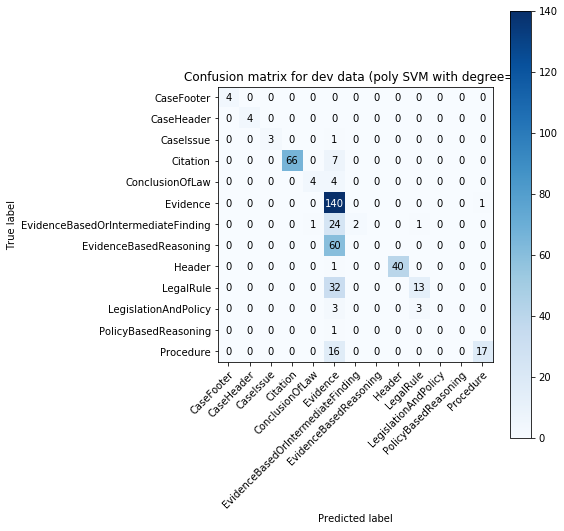

In [3]:
#clf = tree.DecisionTreeClassifier(max_depth=12)
#clf = LogisticRegression()
#clf = RandomForestClassifier(max_depth=12)
clf = make_pipeline(StandardScaler(), SVC(kernel='poly', degree=5, gamma='auto'))
clf = clf.fit(train_X, train_y)
#clf2 = RandomForestClassifier()
#clf2 = clf2.fit(train_X, train_y)
print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X)))
print('DEV TEST:\n'+classification_report(dev_spans_labels, clf.predict(dev_X)))
plot_confusion_matrix(dev_spans_labels, clf.predict(dev_X), classes=list(clf.classes_),
                      title='Confusion matrix for dev data (poly SVM with degree=5)')
print(clf.get_params())
"""
print('TRAIN:\n'+classification_report(train_spans_labels, clf2.predict(train_X)))
print('DEV TEST:\n'+classification_report(dev_spans_labels, clf2.predict(dev_X)))
plot_confusion_matrix(dev_spans_labels, clf2.predict(dev_X), classes=list(clf2.classes_),
                      title='Confusion matrix for dev data (Random Forest)')
forest_trees = [estimator.tree_.max_depth for estimator in clf2.estimators_]
print(len(forest_trees), forest_trees)
"""
plt.show()